# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
# plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/_unconv.zip')
TARGET = 'Prod' # Целевой признак обозначу для удобства
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


None

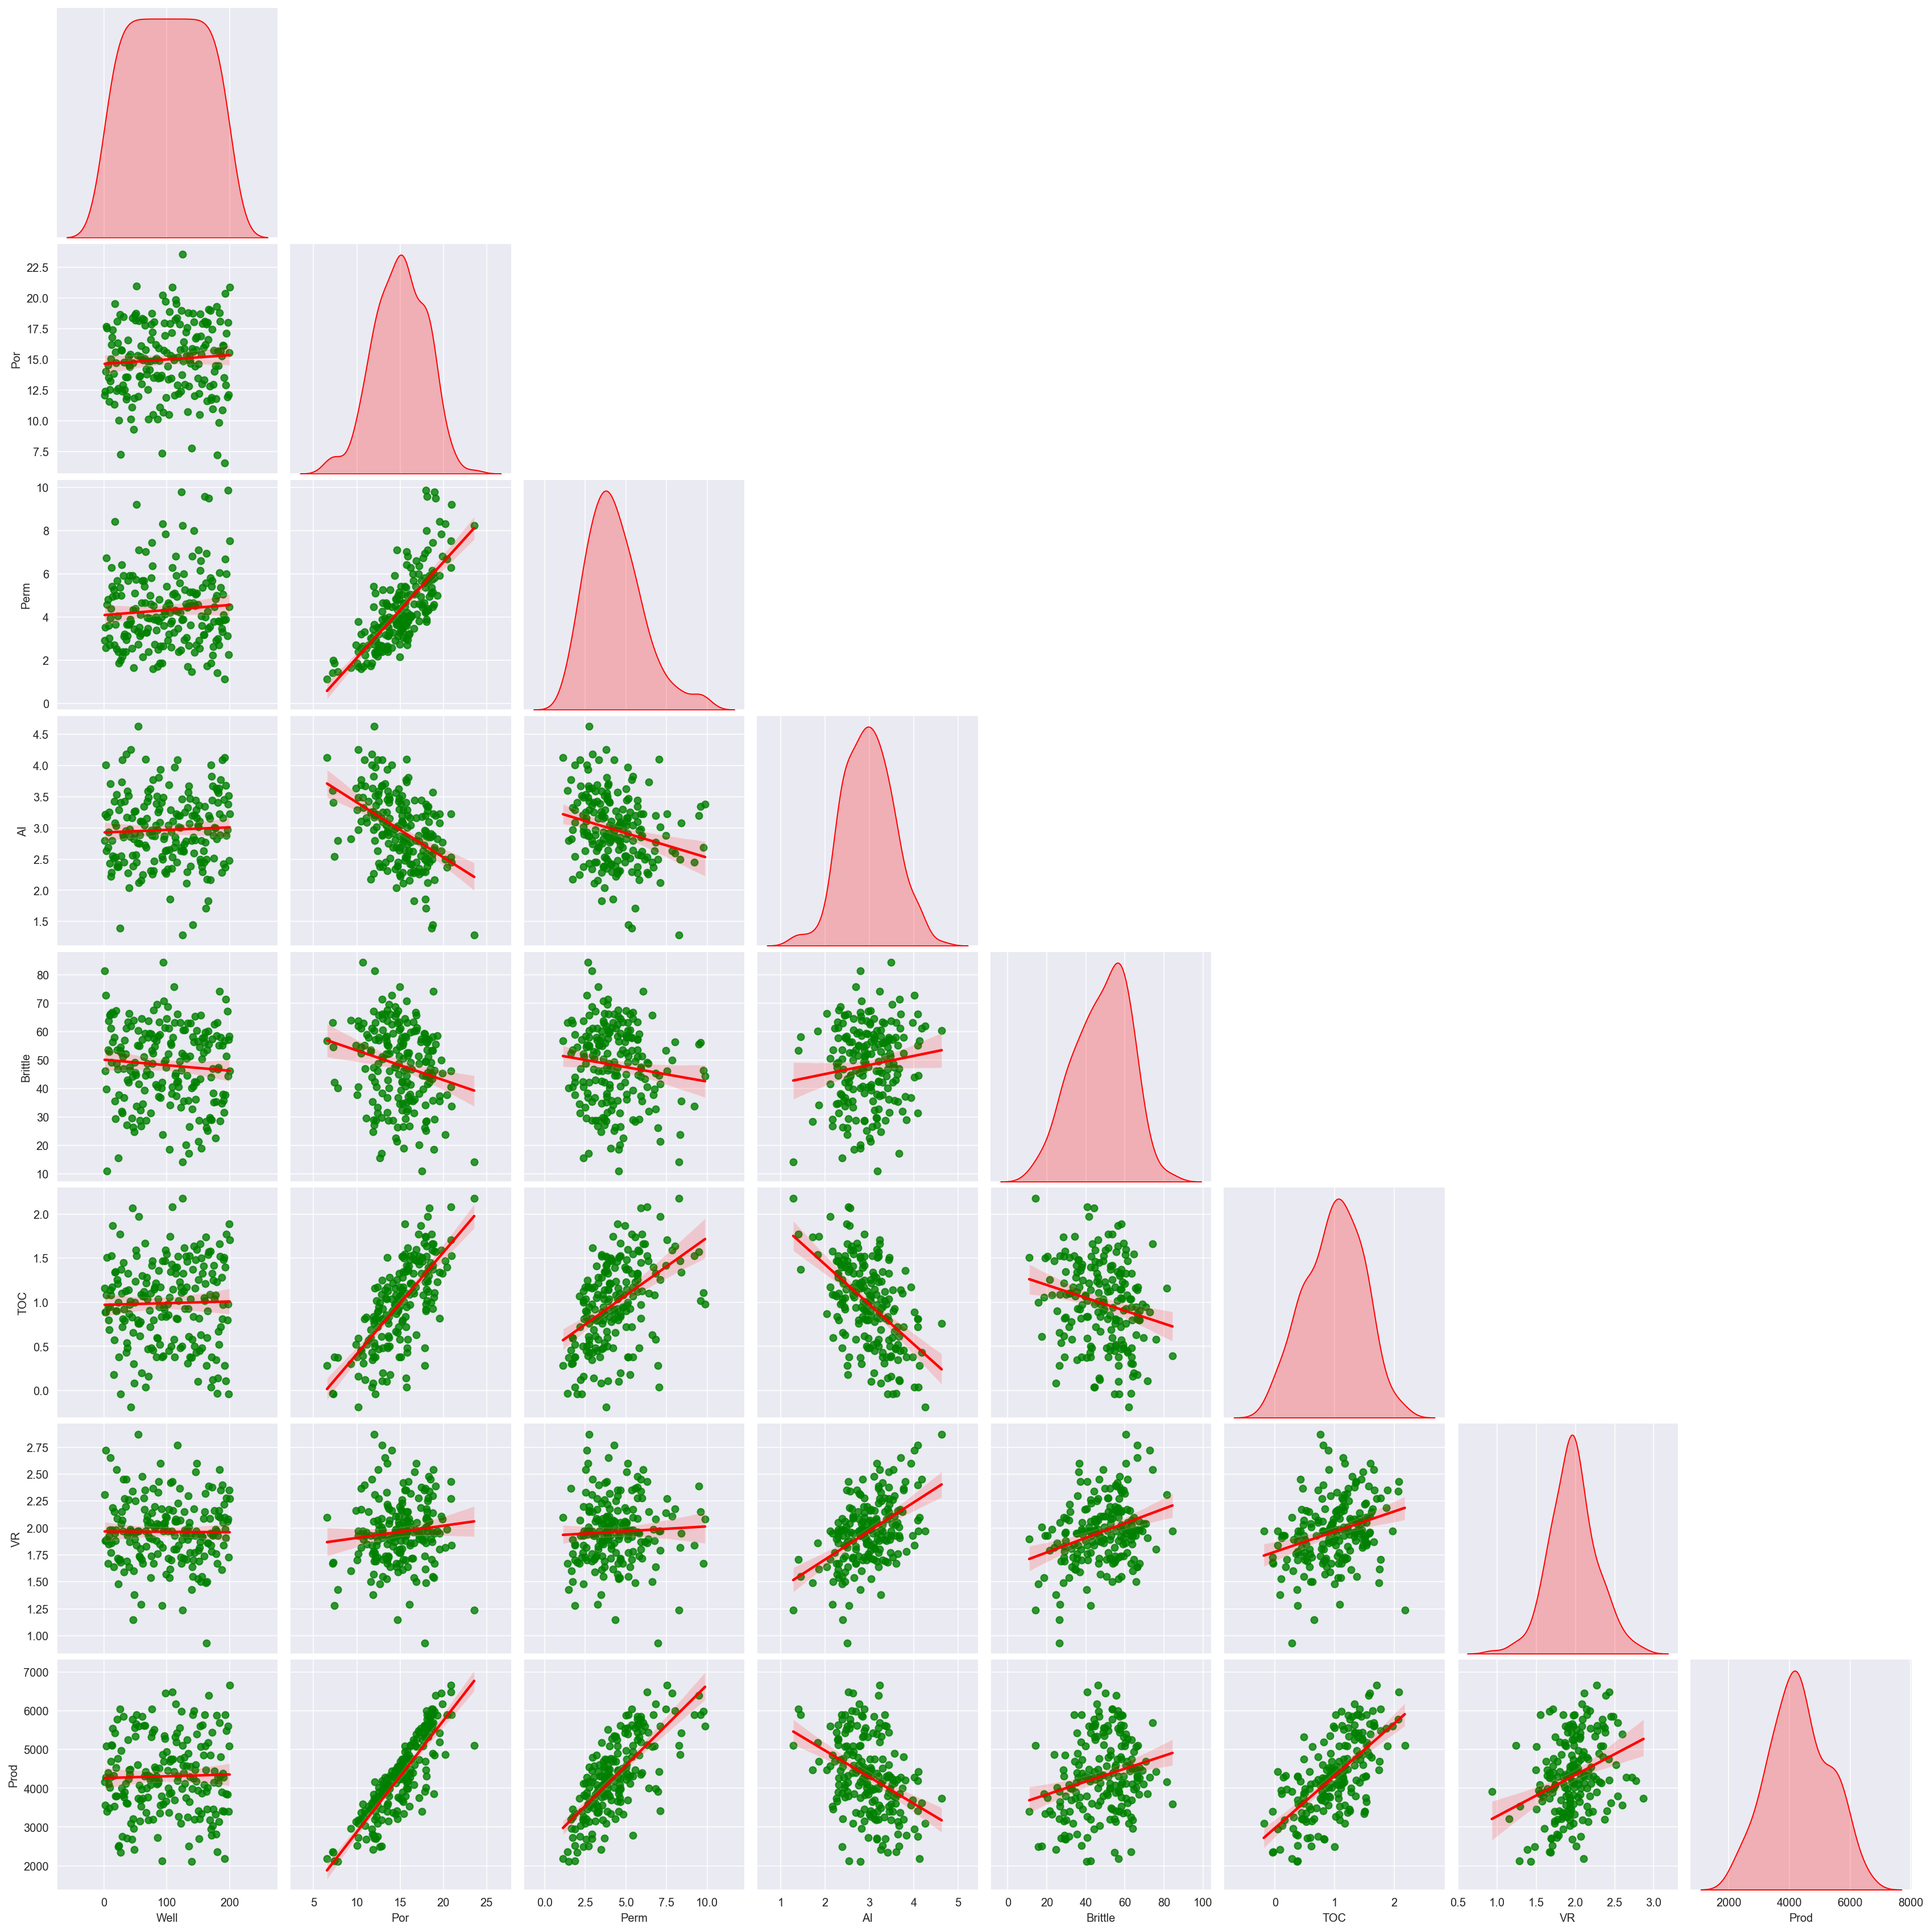

In [3]:
display(data.info())

# Общий попарный анализ всех признаков
sns.pairplot(data, kind='reg', diag_kind='kde',
             plot_kws={'line_kws': {'color': 'red'},
                       'color': 'green'}, diag_kws={'color': 'red'}, corner=True, height=3)
plt.show()

Выводы на основе изучения pairplot:
1. Распределения всех признаков выглядят как нормальное
2. Scatterplot показывает сильную линейную связь между целевым признаком Prod и Por. И линия регрессии при этом имеет наименьную тень и угол в 45 практически.
3. Визуально на втором и третьем месте по важности связи с целевым признаком Prod идут признаки TOC, Perm.
4. В самих признаках вижу сильные линейные связи между Por - Perm, Por - TOC. Потенциально мультиколинеарные признаки.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

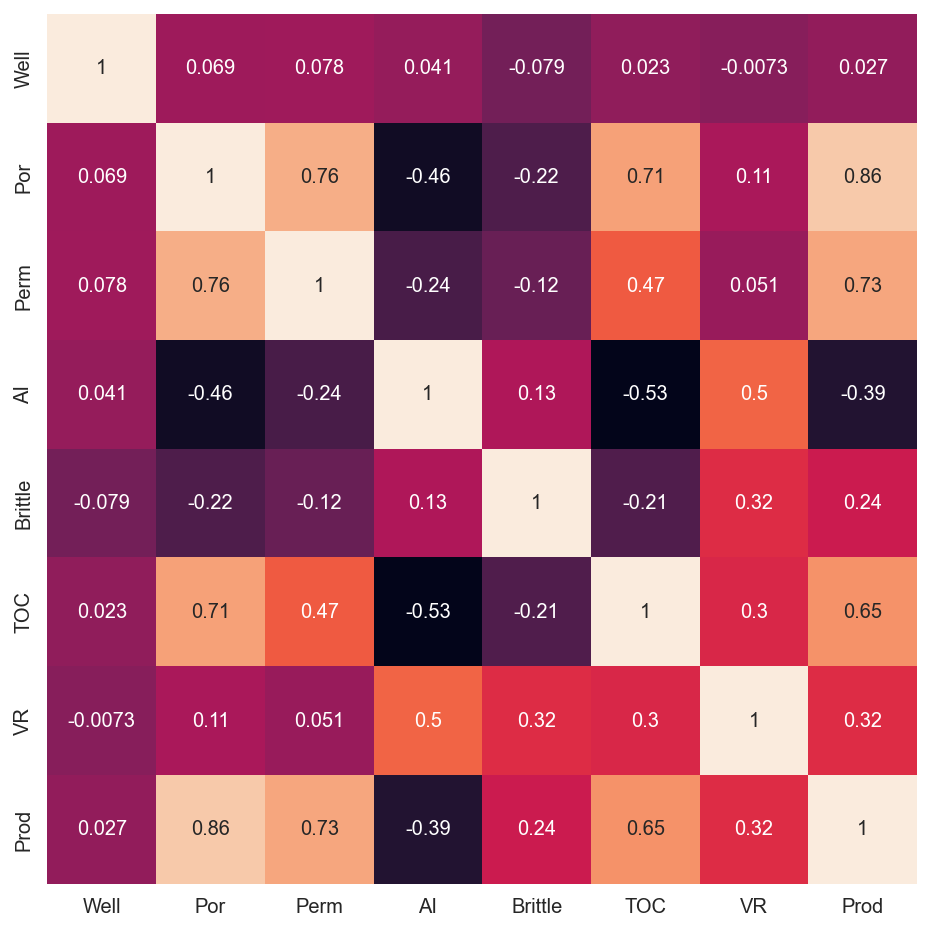

Ранг корреляционной матрицы: 8
Определитель матрицы: 0.0007


In [4]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, square=True, cbar=False)
plt.show()

print('Ранг корреляционной матрицы:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы:', round(np.linalg.det(corr_matrix), 4))

> *Ваши выводы здесь*
1. Пропусков нет. Признак Well это просто номер скажины, информации не несет, необъодимо удалить.
2. Целевой признак Prod наиболее сильно коррелирует со следующими признаками Por, Perm, TOC.
3. Ранг матрицы 8 и соответсвует общему количеству признаков, т.е. явная коллинеарность отсутствует.
4. Определитель 0.0007 т.е. близок к нулю. Матрица плохо обусловлена.
5. Между парами признаков Por/TOC = 0.71, Perm/Por = 0.76 высокая корреляция (> 0.7 = сильная связь). Которая так же подтверждается на соответствующих точечных графиках для которых линейная регрессиия стремится к 45градусам и при этом имеет достаточно небольшое отклонение (смотрю по тени линейной регресии). Т.е. эти попарные корреляции признаков Por/TOC, Perm/Por это не просто цифры, а они подтверждаются линейной свзязью. И это выглядит как мультиколинеарность.
Я бы избавился от TOC, Perm и оставил был Por т.к. он имеет наибольшую корреляцию с целевым признаком.
6. Классическая модель линейной регресии по МНК применима, матрица признаков не выраждена, хотя и плохо обслувлена. Качество модели вызывает вопросы.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [5]:
# Разделяю датасет на матрицу наблюдений и вектор целевого признака
X, y = data.drop(columns=TARGET), data[TARGET]

# Определяю количество записей в матрице
N = X.shape[0]

# Добавляю в начало матрицы вектор единиц для свободного члена
X.insert(0, 'intersept', np.ones(N))
X['intersept'] = X['intersept'].astype(int)

# Формула МНК, результат вектор значений коэффициентов w
w = np.linalg.inv(X.T @ X) @ X.T @ y

# Преобразую в датафрейм, округляю, произвожу приведение типов
w_df = pd.DataFrame({'w_coef': w.round(0).values}, index=X.columns)
w_df['w_coef'] = w_df['w_coef'].astype(int)

w_df

,w_coef
intersept,-1232
Well,0
Por,230
Perm,116
AI,-365
Brittle,25
TOC,-78
VR,785


> *Ваши выводы здесь*
1. Как и было видно изначально, признак Well не несет никакой информации, это просто порядковый номер. Модель присваивает ему фактически нулевой коэффициент.
2. Свободный член intersept = -1232 и говорит о том, что введение каждой новая скважина будет генерировать добычу -1232 млн. кубических футов газа в сутки. Эту добычу можно перевести в долл умножив на текущую цену газа и получить стоимость обслуживания каждой новой скважины в сутки, просто обслуживание, без добычи газа.
3. Так же это значит, что если оценка добычи на новой скважине меньше или не сильно больше 1232 млн. кубических футов газа в сутки, то разрабатывать такую скважину нет никакого экономического смысла.
3. Увеличение пористости скважины Por на 1% приводит к росту добычи на 230 млн. кубических футов газа в сутки.
4. Рост акустический импеданса AI на 1 $кг/м^2 * 10^6$ приводит к снижению добычи на 365 млн. кубических футов газа в сутки.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [6]:
# а)

# Данные новой скважины представлены в виде словаря
well_features = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

# Значение добычи на новой скважине
new_well_target = 4748.315024

# забираю данные в список и добавляю в начало ветрикальный вектор единиц
A = list(well_features.values())
A.insert(0, 1)

# Преобразую серию и список в вектора, хотя это делать не обязательно
A = np.array(A)
w = w.values

# скалярным произведением вектора признаков новой скважины и векторов коэффициентов получаю значение целевого признака
new_well_target_pred = A @ w

# считаю абсолютную ошибку округлив значение до целого
abs_error = np.abs(np.round(new_well_target - new_well_target_pred, 0))
print(f'Абсолютная ошибка для указанной платформы составляет: {abs_error} млн. кубических футов в день')


# б)

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# делаю предсказание для всей выборки X преобразую в матрицу
y_pred = X.values @ w

# преобразую в массив
y_true = y.values

print('Метрики для всей выборки')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_true, y_pred) * 100, 1)} %')
print(f'MAE: {np.round(mean_absolute_error(y_true, y_pred), 3)} млн. кубических футов в день')

Абсолютная ошибка для указанной платформы составляет: 25.0 млн. кубических футов в день
Метрики для всей выборки
MAPE: 3.6 %
MAE: 153.623 млн. кубических футов в день


> *Ваши выводы здесь*

Средняя абсолютная ошибка по всем платформам из выборки равная 3.6% дневной добычи выглядит как достойная работа baseline модели.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [7]:
# Для сравнения коэффициентов с корреляцией добавляю в таблицу значение корреляций признаков к целевому признаку
w_df['corr'] = data.corr()[TARGET].drop(TARGET).round(2)

display(w_df)

,w_coef,corr
intersept,-1232,NaN
Well,0,0.03
Por,230,0.86
Perm,116,0.73
AI,-365,-0.39
Brittle,25,0.24
TOC,-78,0.65
VR,785,0.32


> *Ваши выводы здесь*

Видно, что модель выдала для признака TOC некорректный, отрицательный коэффициент, который противоречит прямой зависимости между TOC и целевым признаком Prod, которая была определена еще на этапе EDA с помощью построения pairplot. 

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [8]:
# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

X, y = new_data.drop(columns=TARGET), data[TARGET]

# Определяю количество записей в матрице
N = X.shape[0]

# Добавляю в начало матрицы вектор единиц для свободного члена
X.insert(0, 'intersept', np.ones(N))
X['intersept'] = X['intersept'].astype(int)

# Формула МНК, результат вектор значений коэффициентов w
w = np.linalg.inv(X.T @ X) @ X.T @ y

# Преобразую в датафрейм, округляю, произвожу приведение типов
w_df = pd.DataFrame({'w_coef': w.round(0).values}, index=X.columns)
w_df['w_coef'] = w_df['w_coef'].astype(int)

w_df['corr'] = data.corr()[TARGET].drop(TARGET).round(2)
display(w_df)

# делаю предсказание для всей выборки X преобразую в матрицу
y_pred = X.values @ w

# преобразую в массив
y_true = y.values

print(f'MAPE: {np.round(mean_absolute_percentage_error(y_true, y_pred) * 100, 1)} %')

,w_coef,corr
intersept,-1835,NaN
Por,293,0.86
AI,-200,-0.39
Brittle,28,0.24
VR,517,0.32


MAPE: 4.0 %


> *Ваши выводы здесь*

Коэффициенты признаков модели стали соответствовать по знаку корреляции с целевым признаком.
Мультиколинеарность побеждена. Но значение метрики все же стало немного хуже, ошибка выросла.
Но тут мы обучаемся на всей выборке и даже без простейшего деления на train/test так что изменение метрики только лишь на одной, тренировочной выборке ни о чем не говорит.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [9]:
from sklearn.linear_model import LinearRegression

# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

X, y = new_data.drop(columns=TARGET), data[TARGET]

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

print(f'MAPE для модели построенной на sklearn реализации LinearRegression: {np.round(mean_absolute_percentage_error(y, y_pred) * 100, 1)} %')

# Значения коэффициентов для модели построенной на sklearn реализации LinearRegression
intersept = pd.DataFrame({'w_coef': lr.intercept_}, index=['intersept'])
all_coef = pd.DataFrame({'w_coef': lr.coef_}, index=X.columns)
w_df = pd.concat([intersept, all_coef]).round(0).astype(int)

display(w_df)

MAPE для модели построенной на sklearn реализации LinearRegression: 4.0 %


,w_coef
intersept,-1835
Por,293
AI,-200
Brittle,28
VR,517


> *Ваши выводы здесь*

Результаты модели и коэффициенты не отличаются от модели построенной вручную.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [10]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [11]:
# Список для сбора информации по всем моделям
info_models_list = []

# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

# создание матрицы факторов и вектора целевого признака
X, y = new_data.drop(columns=TARGET), data[TARGET]

# стандартизация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# создание полиноминальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
print(f'После полиноминальной генерации стало {X.shape[1]} признака.')

# создание объекта кросс-валидации
cv_metrics = cross_validate(
    estimator=LinearRegression(), # модель
    X=X, # матрица наблюдений X
    y=y, # вектор ответов y
    cv=5, # кросс-валидатор
    scoring='neg_mean_absolute_percentage_error', # метрика
    return_train_score=True # подсчёт метрики на тренировочных фолдах
)

# Средние значения метрик перевожу в проценты и умножаю на -1 т.к. в cross_validate используется отрицательное значение для максимизации значения 
train_mape = cv_metrics['train_score'].mean() * 100 * -1
test_mape = cv_metrics['test_score'].mean() * 100 * -1

print()
print('***Модель линейной регрессии на полиноминальных признаках 3ей степени, без регуляризации***')
print(f'Среднее значение MAPE на тренировочной выборке: {train_mape:.2f}%')
print(f'Среднее значение MAPE на тестовой выборке: {test_mape:.2f}%')


model_info = {'Model': 'LinearRegression', 'Hyperparams': '', 'Polynomial Features': 'Yes', 'Train MAPE, %': train_mape, 'Valid MAPE, %': test_mape}
info_models_list.append(model_info)

После полиноминальной генерации стало 34 признака.

***Модель линейной регрессии на полиноминальных признаках 3ей степени, без регуляризации***
Среднее значение MAPE на тренировочной выборке: 1.77%
Среднее значение MAPE на тестовой выборке: 2.68%


> *Ваши выводы здесь*

Использование полиноминальной модели третьего порядка улучшило результаты модели, если сравнивать с обычной линейной регрессией на всей выборке без кросс-валидации из предыдущего задания, значение которой составляло 4%.

Разброс выглядит нормально, на тестовой выборке метрика лучше чем в предыдщум задании, где подбор параметров осущесвлялся на всей выборке.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [12]:
# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

# создание матрицы факторов и вектора целевого признака
X, y = new_data.drop(columns=TARGET), data[TARGET]

# разделение выборок
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# создаю пайплайн предобработки
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('lasso', Lasso(max_iter=10000, random_state=42))
])

# Определяю сетку гиперпараметров
param_grid = {
    'lasso__alpha': np.logspace(-4, 1, 6)
}

# создаю объект поиска по сетке
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5, # кросс-валидатор
    scoring='neg_mean_absolute_percentage_error', # метрика
    return_train_score=True, # подсчёт метрики на тренировочных фолдах
    n_jobs=-1
)

print('***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L1***')
# обучаю модель
grid_search.fit(X_train, y_train)
print(f'Наилучшие значения гиперпараметров полученные на кросс-валидации: {grid_search.best_params_}')
print(f'Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: {grid_search.best_score_ * 100 * -1:.2f}%')

# делаю предсказания на основе лучшего параметра отобранного на кросс-валидации
y_train_pred = grid_search.predict(X_train)
y_valid_pred = grid_search.predict(X_valid)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
valid_mape = mean_absolute_percentage_error(y_valid, y_valid_pred) * 100

print()
print(f'Среднее значение MAPE на тренировочной выборке: {train_mape:.2f}%')
print(f'Среднее значение MAPE на валидационной выборке: {valid_mape:.2f}%')

model_info = {'Model': 'Lasso', 'Hyperparams': grid_search.best_params_, 'Polynomial Features': 'Yes', 'Train MAPE, %': train_mape, 'Valid MAPE, %': valid_mape}
info_models_list.append(model_info)

***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L1***


Наилучшие значения гиперпараметров полученные на кросс-валидации: {'lasso__alpha': 10.0}
Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: 2.40%

Среднее значение MAPE на тренировочной выборке: 1.98%
Среднее значение MAPE на валидационной выборке: 2.11%


> *Ваши выводы здесь*

Подбор коэффициента регуляризации по сетке и с кросс-валидацией для можели Lasso привел к улучшению метрик MAPE на всех выборках и снижению разброса между тестовой и валидационной выборкой.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [13]:
# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

# создание матрицы факторов и вектора целевого признака
X, y = new_data.drop(columns=TARGET), data[TARGET]

# разделение выборок
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# создаю пайплайн предобработки
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('rige', Ridge(max_iter=10000, random_state=42))
])

# Определяю сетку гиперпараметров
param_grid = {
    'rige__alpha': np.logspace(-4, 1, 6)
}

# создаю объект поиска по сетке
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5, # кросс-валидатор
    scoring='neg_mean_absolute_percentage_error', # метрика
    return_train_score=True, # подсчёт метрики на тренировочных фолдах
    n_jobs=-1
)

print('***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L2***')
# обучаю модель
grid_search.fit(X_train, y_train)
print(f'Наилучшие значения гиперпараметров полученные на кросс-валидации: {grid_search.best_params_}')
print(f'Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: {grid_search.best_score_ * 100 * -1:.2f}%')

# делаю предсказания на основе лучшего параметра отобранного на кросс-валидации
y_train_pred = grid_search.predict(X_train)
y_valid_pred = grid_search.predict(X_valid)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
valid_mape = mean_absolute_percentage_error(y_valid, y_valid_pred) * 100

print()
print(f'Среднее значение MAPE на тренировочной выборке: {train_mape:.2f}%')
print(f'Среднее значение MAPE на валидационной выборке: {valid_mape:.2f}%')

model_info = {'Model': 'Ridge', 'Hyperparams': grid_search.best_params_, 'Polynomial Features': 'Yes', 'Train MAPE, %': train_mape, 'Valid MAPE, %': valid_mape}
info_models_list.append(model_info)

***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L2***
Наилучшие значения гиперпараметров полученные на кросс-валидации: {'rige__alpha': 0.1}
Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: 2.70%

Среднее значение MAPE на тренировочной выборке: 1.80%
Среднее значение MAPE на валидационной выборке: 2.35%


> *Ваши выводы здесь*

L2 регуляция не позволила улучшить результаты по сравнению с L1

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
# Список признаков для удаления
col_to_del = ['Well', 'Perm', 'TOC']
new_data = data.drop(columns=col_to_del)

# создание матрицы факторов и вектора целевого признака
X, y = new_data.drop(columns=TARGET), data[TARGET]

# разделение выборок
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# создаю пайплайн предобработки
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('elast', ElasticNet(max_iter=10000, random_state=42))
])

# Определяю сетку гиперпараметров
param_grid = {
    'elast__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'elast__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# создаю объект поиска по сетке
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5, # кросс-валидатор
    scoring='neg_mean_absolute_percentage_error', # метрика
    return_train_score=True, # подсчёт метрики на тренировочных фолдах
    n_jobs=-1
)

print('***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L1-L2(ElasticNet)***')
# обучаю модель
grid_search.fit(X_train, y_train)
print(f'Наилучшие значения гиперпараметров полученные на кросс-валидации: {grid_search.best_params_}')
print(f'Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: {grid_search.best_score_ * 100 * -1:.2f}%')

# делаю предсказания на основе лучшего параметра отобранного на кросс-валидации
y_train_pred = grid_search.predict(X_train)
y_valid_pred = grid_search.predict(X_valid)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
valid_mape = mean_absolute_percentage_error(y_valid, y_valid_pred) * 100

print()
print(f'Среднее значение MAPE на тренировочной выборке: {train_mape:.2f}%')
print(f'Среднее значение MAPE на валидационной выборке: {valid_mape:.2f}%')

model_info = {'Model': 'ElasticNet', 'Hyperparams': grid_search.best_params_, 'Polynomial Features': 'Yes', 'Train MAPE, %': train_mape, 'Valid MAPE, %': valid_mape}
info_models_list.append(model_info)

***Модель линейной регрессии на полиноминальных признаках 3ей степени, c регуляризацией L1-L2(ElasticNet)***


Наилучшие значения гиперпараметров полученные на кросс-валидации: {'elast__alpha': 10, 'elast__l1_ratio': 1}
Среднее наилучшее значение метрики MAPE на тестовых фолдах кросс-валидации: 2.40%

Среднее значение MAPE на тренировочной выборке: 1.98%
Среднее значение MAPE на валидационной выборке: 2.11%


> *Ваши выводы здесь*

Перебор параметров по сетке фактически привел к L1 регуляризации, elast__l1_ratio = 1 обнулил влияние регуляризации L2.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
final_info = pd.DataFrame(info_models_list).round(2)
final_info

,Model,Hyperparams,Polynomial Features,"Train MAPE, %","Valid MAPE, %"
0,LinearRegression,,Yes,1.77,2.68
1,Lasso,{'lasso__alpha': 10.0},Yes,1.98,2.11
2,Ridge,{'rige__alpha': 0.1},Yes,1.80,2.35
3,ElasticNet,"{'elast__alpha': 10, 'elast__l1_ratio': 1}",Yes,1.98,2.11


> *Ваши выводы здесь*

Модель на основе Lasso выглядит лучше всего.
 
Разброс наименьший из всех моделей, за счет чуть большего смещения на тренировочной выборке.